In [1]:
# general imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# deep learning libraries
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# image manipulation libraries
from skimage.io import imread
from skimage.util import crop
from skimage.transform import resize
from PIL import Image

##Testing Example Coin Images

Reals image size: 
(250, 244)


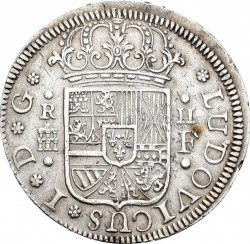

In [2]:
# get images for base testing
reals = Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_imgs/example_reals.jpg')
escudos = Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_imgs/example_escudos.jpg')

print("Reals image size: ")
print(reals.size)
reals

Escusods image size: 
(249, 244)


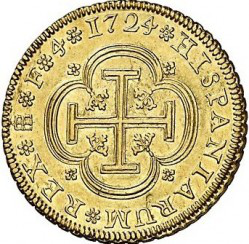

In [3]:
print("Escusods image size: ")
print(escudos.size)
escudos

In [4]:
# resize
reals = reals.resize((50,50))
escudos = escudos.resize((50,50))

(50, 50, 3)


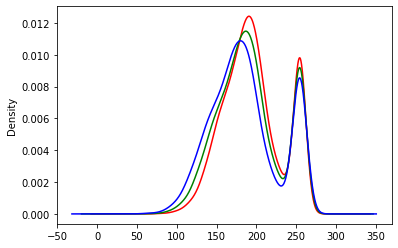

In [5]:
# turn images into arrays
reals_data = np.array(reals)
escudos_data = np.array(escudos)
print(reals_data.shape)

# plot color channels for real
for layer, color in enumerate(['r','g','b']):
    pd.Series(reals_data[:,:,layer].flatten()).plot.density(c=color)
plt.show()

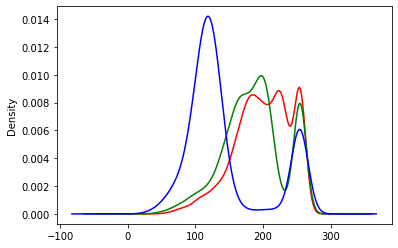

In [6]:
# plot color channels for the escudo
for layer, color in enumerate(['r','g','b']):
    pd.Series(escudos_data[:,:,layer].flatten()).plot.density(c=color)
plt.show()

##Image Processing and Pirate Brain Thinking

In [7]:
img_data_list = []
label_list = []
for filename in os.listdir('drive/MyDrive/CoinsOfTheSevenSeas/scraped_coins'):
  # process image
  image = Image.open('drive/MyDrive/CoinsOfTheSevenSeas/scraped_coins/'+filename)
  image = image.resize((250,250)).crop(box=(30,30,220,220))
  image_data = np.asarray(image.resize((50,50)))

  # find if real or escudos and append tuple to list
  if ("real" in filename):
    img_data_list.append(image_data)
    label_list.append(0.)
  elif ("escudo" in filename):
    img_data_list.append(image_data)
    label_list.append(1.)

coin_imgs = np.array(img_data_list)
coin_labels = np.array(label_list)

def get_image_data(filename):
  image = Image.open(filename).resize((250,250)) # initial resize so cropping works for any size image
  image = image.crop(box=(30,30,220,220)).resize((50,50)) # crop and resize again
  return np.asarray(image) # return image as array

In [8]:
# split data into train, test, and evaluation sets
x_temp, x_eval, y_temp, y_eval = train_test_split(coin_imgs, coin_labels, test_size=.1)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=.2)

print("Eval sample #: %s"%len(x_eval))
print("Test sample #: %s"%len(x_test))
print("Train sample #: %s"%len(x_train))

Eval sample #: 17
Test sample #: 31
Train sample #: 120


In [9]:
# build model
model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3))) # convolutional networks to make image smaller
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # pool pixels to get largest value
model.add(Flatten()) # flatten model to prepare for hidden layer
model.add(Dense(40, activation='relu')) # fully connected, 'hidden' layer
'''can add dropout here if model overfits'''
model.add(Dense(1, activation='sigmoid')) # prediction layer

# show summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 40)                1354280   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 1,373,713
Trainable params: 1,373,713
Non-trainable params: 0
______________________________________________

In the model above, we are left with one output for prediction between 0 and 1 due to the sigmoid function.
This ouput correlates to what the model thinks is the percentage chance for the given image to be a reals: closer to one equates to an escudos, closer to zero a reals.

In [10]:
stop_early = keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=.001), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[stop_early])

test_eval = model.evaluate(x_test, y_test, verbose=False)
eval_eval = model.evaluate(x_eval, y_eval, verbose=False)
print("Test loss, accuracy: %s, %s" % (test_eval[0], test_eval[1]))
print("Eval loss, accuracy: %s, %s" % (eval_eval[0], eval_eval[1]))

Epoch 1/200
4/4 [==============================] - 2s 407ms/step - loss: 230.7161 - accuracy: 0.5337 - val_loss: 34.7648 - val_accuracy: 0.5806
Epoch 2/200
4/4 [==============================] - 1s 265ms/step - loss: 26.0295 - accuracy: 0.5008 - val_loss: 5.2910 - val_accuracy: 0.5806
Epoch 3/200
4/4 [==============================] - 1s 270ms/step - loss: 3.7431 - accuracy: 0.6010 - val_loss: 1.5296 - val_accuracy: 0.8710
Epoch 4/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6822 - accuracy: 0.9112 - val_loss: 0.2727 - val_accuracy: 0.9355
Epoch 5/200
4/4 [==============================] - 1s 262ms/step - loss: 0.2974 - accuracy: 0.9410 - val_loss: 0.3759 - val_accuracy: 0.9677
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.1299 - accuracy: 0.9740 - val_loss: 0.8148 - val_accuracy: 0.9355
Epoch 7/200
4/4 [==============================] - 1s 265ms/step - loss: 2.8629e-06 - accuracy: 1.0000 - val_loss: 7.6784e-05 - val_accuracy: 1.0000
E

##Testing Trained Model

In [11]:
def test_pred(fname):
  image = Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/'+fname)
  image = image.crop(box=(30,30,220,220)).resize((50,50))
  if (model.predict(np.expand_dims(np.asarray(image), axis=0)) > 0.5):
    print("Escudo Predicted")
  else:
    print("Real Predicted")

Escudo Predicted


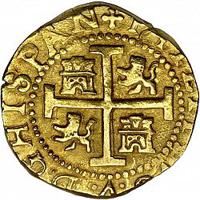

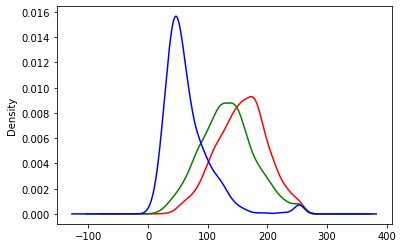

In [12]:
test_pred('escudos.jpg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos.jpg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos.jpg').resize((200,200))

Real Predicted


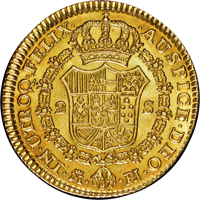

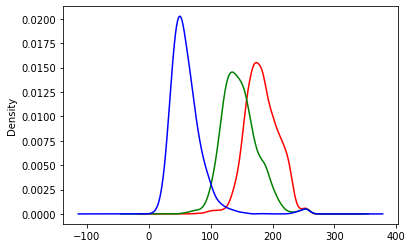

In [13]:
test_pred('escudos1.jpg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos1.jpg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos1.jpg').resize((200,200))

Escudo Predicted


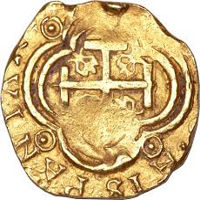

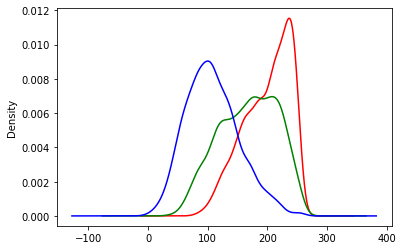

In [14]:
test_pred('escudos2.jpeg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos2.jpeg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/escudos2.jpeg').resize((200,200))

Real Predicted


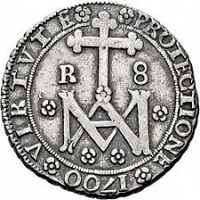

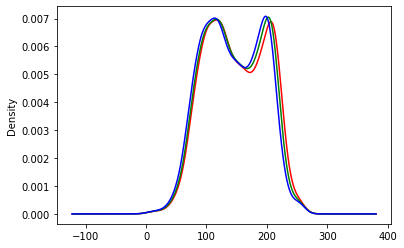

In [15]:
test_pred('reals.jpeg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals.jpeg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals.jpeg').resize((200,200))

Real Predicted


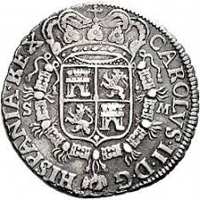

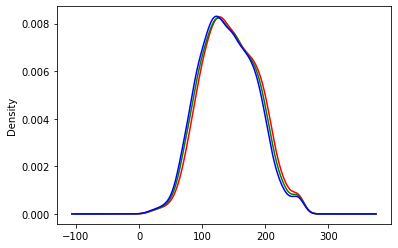

In [16]:
test_pred('reals1.jpeg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals1.jpeg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals1.jpeg').resize((200,200))

Real Predicted


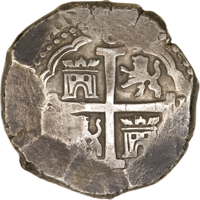

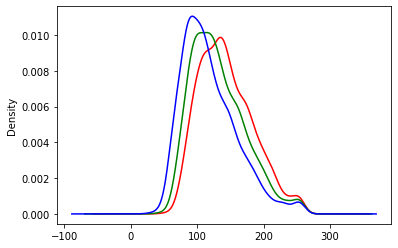

In [17]:
test_pred('reals2.jpg')

single_image_data = get_image_data('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals2.jpg')
for layer, color in enumerate(['r','g','b']):
    pd.Series(single_image_data[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/CoinsOfTheSevenSeas/coins_test/reals2.jpg').resize((200,200))